# Regional Effects (unknown black-box function)

This tutorial use the same dataset with the previous [tutorial](./03_regional_effects_synthetic_f/), but instead of explaining the known (synthetic) predictive function, we fit a neural network on the data and explain the neural network. This is a more realistic scenario, since in real-world applications we do not know the underlying function and we only have access to the data. We advise the reader to first read the previous tutorial.

In [34]:
import numpy as np
import effector
import keras
import tensorflow as tf

np.random.seed(12345)
tf.random.set_seed(12345)

## Simulation example

### Data Generating Distribution

We will generate $N=500$ examples with $D=3$ features, which are in the uncorrelated setting all uniformly distributed as follows:

<center>

| Feature | Description                                | Distribution                 |
|---------|--------------------------------------------|------------------------------|
| $x_1$   | Uniformly distributed between $-1$ and $1$ | $x_1 \sim \mathcal{U}(-1,1)$ |
| $x_2$   | Uniformly distributed between $-1$ and $1$ | $x_2 \sim \mathcal{U}(-1,1)$ |
| $x_3$   | Uniformly distributed between $-1$ and $1$ | $x_3 \sim \mathcal{U}(-1,1)$ |

</center>

For the correlated setting we keep the distributional assumptions for $x_2$ and $x_3$ but define $x_1$ such that it is highly correlated with $x_3$ by: $x_1 = x_3 + \delta$ with $\delta \sim \mathcal{N}(0,0.0625)$.

In [35]:
def generate_dataset_uncorrelated(N):
    x1 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x3 = np.random.uniform(-1, 1, size=N)
    return np.stack((x1, x2, x3), axis=-1)

def generate_dataset_correlated(N):
    x3 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x1 = x3 + np.random.normal(loc = np.zeros_like(x3), scale = 0.25)
    return np.stack((x1, x2, x3), axis=-1)

# generate the dataset for the uncorrelated and correlated setting
N = 1000
X_uncor_train = generate_dataset_uncorrelated(N)
X_uncor_test = generate_dataset_uncorrelated(10000)
X_cor_train = generate_dataset_correlated(N)
X_cor_test = generate_dataset_correlated(10000)

### Black-box function

We will use the following linear model with a subgroup-specific interaction term:
 $$ y = 3x_1I_{x_3>0} - 3x_1I_{x_3\leq0} + x_3$$ 
 
On a global level, there is a high heterogeneity for the features $x_1$ and $x_3$ due to their interaction with each other. However, this heterogeneity vanishes to 0 if the feature space is separated into subregions:

<center>

| Feature | Region      | Average Effect | Heterogeneity |
|---------|-------------|----------------|---------------|
| $x_1$   | $x_3>0$     | $3x_1$         | 0             |
| $x_1$   | $x_3\leq 0$ | $-3x_1$        | 0             |
| $x_2$   | all         | 0              | 0             |
| $x_3$   | $x_3>0$     | $x_3$          | 0             |
| $x_3$   | $x_3\leq 0$ | $x_3$          | 0             |

</center>

In [36]:
def generate_target(X):
    f = np.where(X[:,2] > 0, 3*X[:,0] + X[:,2], -3*X[:,0] + X[:,2])
    epsilon = np.random.normal(loc = np.zeros_like(X[:,0]), scale = 0.1)
    Y = f + epsilon
    return(Y)

# generate target for uncorrelated and correlated setting
Y_uncor_train = generate_target(X_uncor_train)
Y_uncor_test = generate_target(X_uncor_test)
Y_cor_train = generate_target(X_cor_train)
Y_cor_test = generate_target(X_cor_test)      

### Fit a Neural Network

We create a two-layer feedforward Neural Network, a weight decay of 0.01 for 100 epochs. We train two instances of this NN, one on the uncorrelated and one on the correlated setting. In both cases, the NN achieves a Mean Squared Error of about $0.17$ units.

In [37]:
# Train - Evaluate - Explain a neural network
model_uncor = keras.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model_uncor.compile(optimizer=optimizer, loss="mse")
model_uncor.fit(X_uncor_train, Y_uncor_train, epochs=100)
model_uncor.evaluate(X_uncor_test, Y_uncor_test)

Epoch 1/100
32/32 [==============================] - 0s 1ms/step - loss: 2.4792
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 0.8556
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 0.3830
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: 0.2637
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - loss: 0.2191
Epoch 6/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1843
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1651
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.1473
Epoch 9/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1447
Epoch 10/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1520
Epoch 11/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1299
Epoch 12/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1255
Epoch 13/100
32/32 [=================

0.04788530245423317

In [38]:
model_cor = keras.Sequential([
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(10, activation="relu", input_shape=(3,)),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model_cor.compile(optimizer=optimizer, loss="mse")
model_cor.fit(X_cor_train, Y_cor_train, epochs=100)
model_cor.evaluate(X_cor_test, Y_cor_test)

Epoch 1/100
32/32 [==============================] - 0s 1ms/step - loss: 1.7385
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.4965
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 0.2288
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.1634
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1332
Epoch 6/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1123
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0996
Epoch 8/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0914
Epoch 9/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0864
Epoch 10/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0845
Epoch 11/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0782
Epoch 12/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0744
Epoch 13/100
32/32 [=================

0.03737838566303253

---
## PDP
### Uncorrelated setting
#### Global PDP

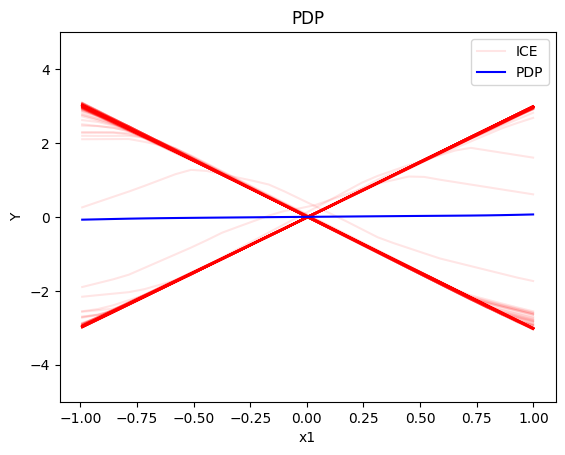

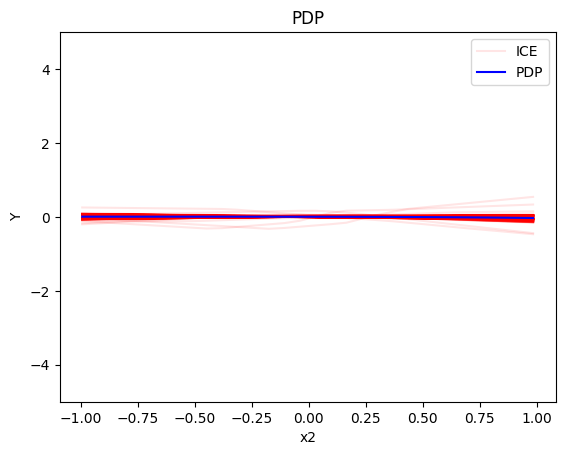

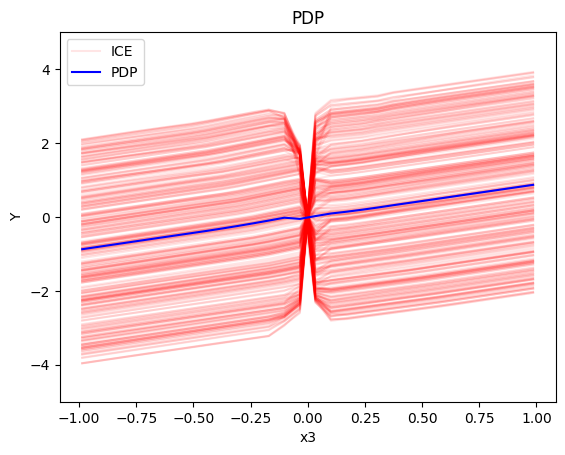

In [39]:
pdp = effector.PDP(data=X_uncor_train, model=model_uncor, feature_names=['x1','x2','x3'], target_name="Y")
pdp.plot(feature=0, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=1, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=2, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])

#### Regional PDP

In [40]:
regional_pdp = effector.RegionalPDP(data=X_uncor_train, model=model_uncor, feature_names=['x1','x2','x3'], axis_limits=np.array([[-1,1],[-1,1],[-1,1]]).T)
regional_pdp.fit(features="all", heter_pcg_drop_thres=0.3, nof_candidate_splits_for_numerical=11)

100%|██████████| 3/3 [00:00<00:00,  5.94it/s]


In [41]:
regional_pdp.show_partitioning(features=0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 1.72 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x1 | x3 <= -0.0, heter: 0.32 || nof_instances:   498 || weight: 0.50
        Node id: 2, name: x1 | x3  > -0.0, heter: 0.32 || nof_instances:   502 || weight: 0.50
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 1.72
        Level 1, heter: 0.32 || heter drop: 1.40 (81.48%)


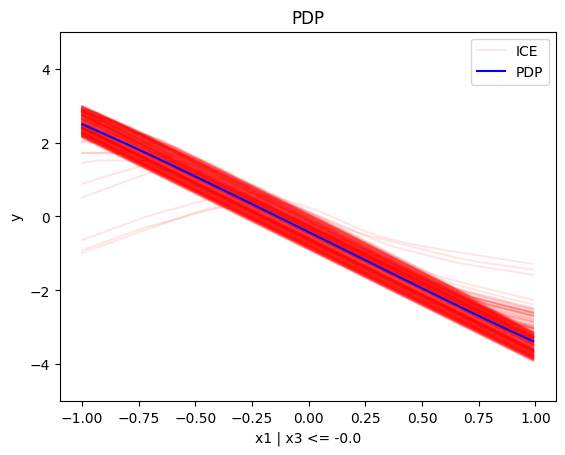

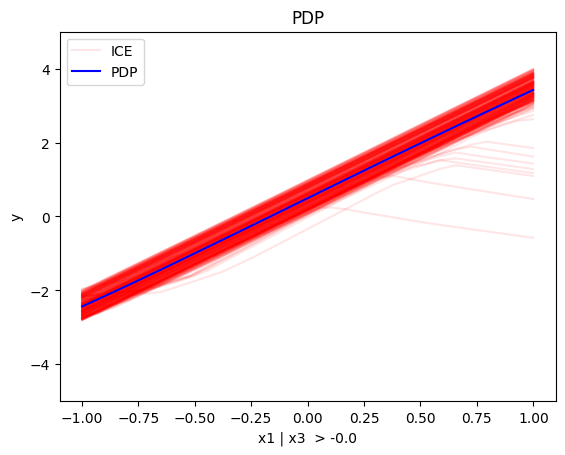

In [42]:
regional_pdp.plot(feature=0, node_idx=1, heterogeneity="ice", y_limits=[-5, 5])
regional_pdp.plot(feature=0, node_idx=2, heterogeneity="ice", y_limits=[-5, 5])

In [43]:
regional_pdp.show_partitioning(features=1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 1.81 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 1.81


In [44]:
regional_pdp.show_partitioning(features=2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 1.73 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x3 | x1 <= -0.0, heter: 0.86 || nof_instances:   494 || weight: 0.49
        Node id: 2, name: x3 | x1  > -0.0, heter: 0.86 || nof_instances:   506 || weight: 0.51
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 1.73
        Level 1, heter: 0.86 || heter drop: 0.87 (50.34%)


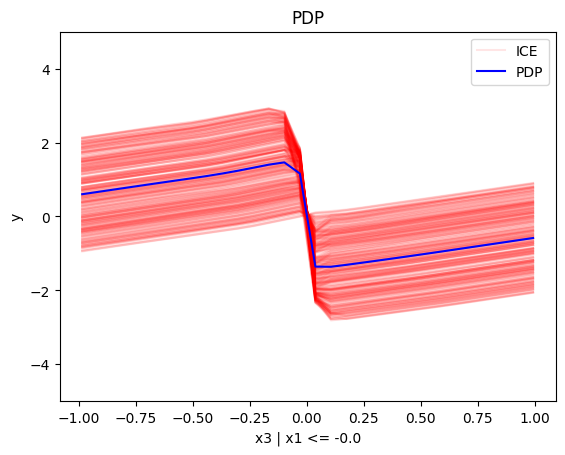

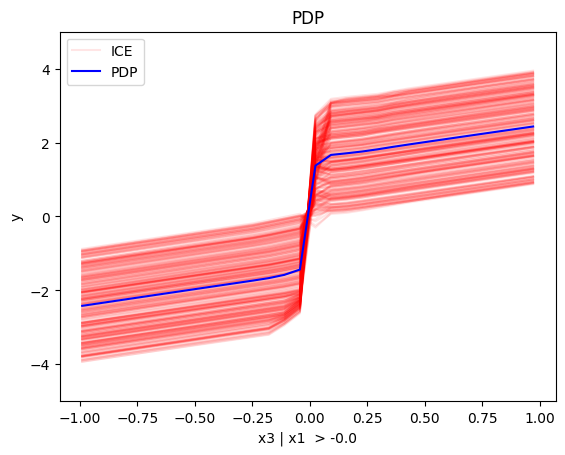

In [45]:
regional_pdp.plot(feature=2, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
regional_pdp.plot(feature=2, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

#### Conclusion

For the Global PDP:

   * the average effect of $x_1$ is $0$ with some heterogeneity implied by the interaction with $x_1$. The heterogeneity is expressed with two opposite lines; $-3x_1$ when $x_1 \leq 0$ and $3x_1$ when $x_1 >0$
   * the average effect of $x_2$ to be $0$ without heterogeneity
   * the average effect of $x_3$ to be $x_3$ with some heterogeneity due to the interaction with $x_1$. The heterogeneity is expressed with a discontinuity around $x_3=0$, with either a positive or a negative offset depending on the value of $x_1^i$

--- 

For the Regional PDP:

* For $x_1$, the algorithm finds two regions, one for $x_3 \leq 0$ and one for $x_3 > 0$
  * when $x_3>0$ the effect is $3x_1$
  * when $x_3 \leq 0$, the effect is $-3x_1$
* For $x_2$ the algorithm does not find any subregion 
* For $x_3$, there is a change in the offset:
  * when $x_1>0$ the line is $x_3 - 3x_1^i$ in the first half and $x_3 + 3x_1^i$ later
  * when $x_1<0$ the line is $x_3 + 3x_1^i$ in the first half and $x_3 - 3x_1^i$ later

### Correlated setting


#### Global PDP

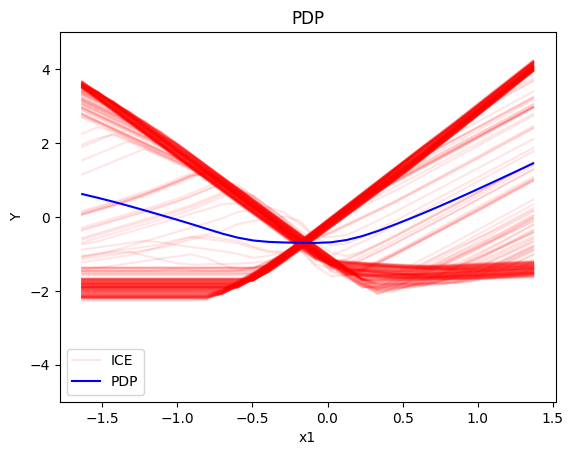

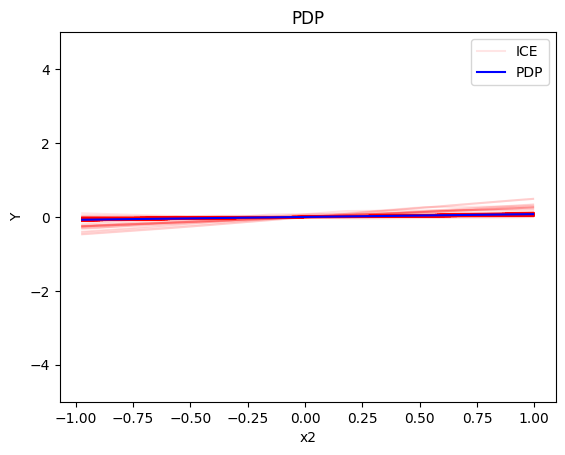

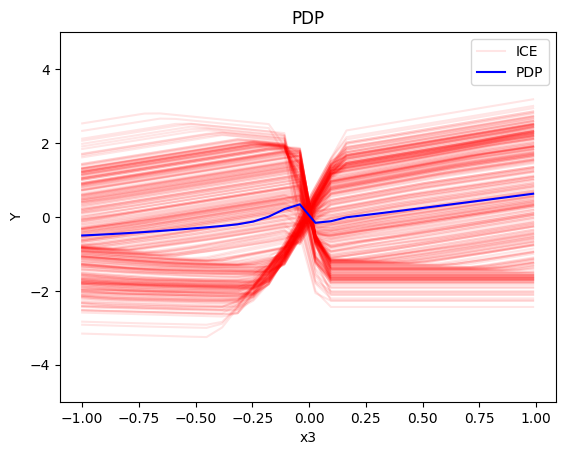

In [46]:
pdp = effector.PDP(data=X_cor_train, model=model_cor, feature_names=['x1','x2','x3'], target_name="Y")
pdp.plot(feature=0, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=1, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=2, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])

#### Regional-PDP

In [47]:
regional_pdp = effector.RegionalPDP(data=X_cor_train, model=model_cor, feature_names=['x1','x2','x3'], axis_limits=np.array([[-1,1],[-1,1],[-1,1]]).T)
regional_pdp.fit(features="all", heter_pcg_drop_thres=0.4, nof_candidate_splits_for_numerical=11)

100%|██████████| 3/3 [00:00<00:00,  5.85it/s]


In [48]:
regional_pdp.show_partitioning(features=0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 1.63 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x1 | x3 <= -0.0, heter: 0.42 || nof_instances:   491 || weight: 0.49
        Node id: 2, name: x1 | x3  > -0.0, heter: 0.41 || nof_instances:   509 || weight: 0.51
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 1.63
        Level 1, heter: 0.41 || heter drop: 1.22 (74.70%)


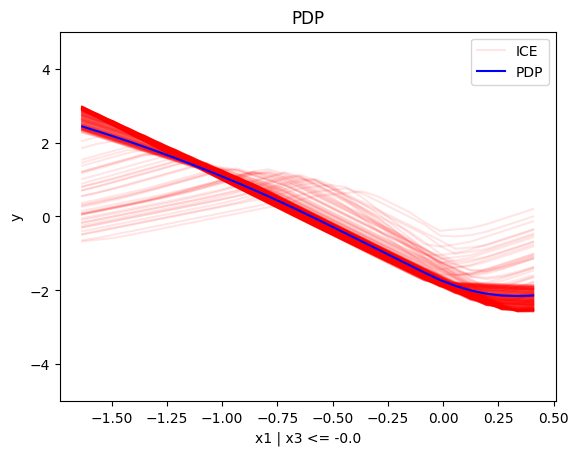

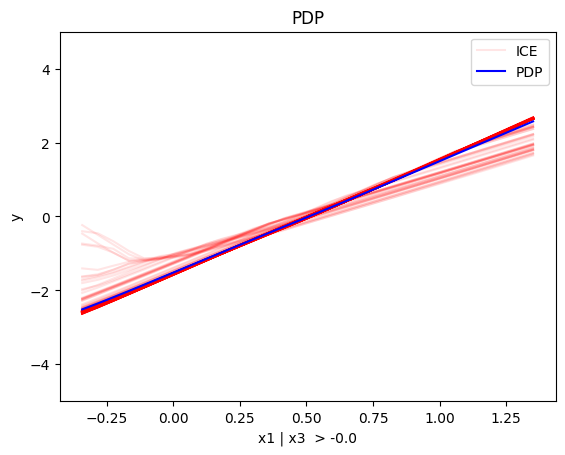

In [49]:
regional_pdp.plot(feature=0, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
regional_pdp.plot(feature=0, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

In [50]:
regional_pdp.show_partitioning(features=1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 1.28 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 1.28


In [51]:
regional_pdp.show_partitioning(features=2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 1.39 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x3 | x1 <= -0.13, heter: 0.71 || nof_instances:   447 || weight: 0.45
        Node id: 2, name: x3 | x1  > -0.13, heter: 0.79 || nof_instances:   553 || weight: 0.55
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 1.39
        Level 1, heter: 0.75 || heter drop: 0.64 (45.97%)


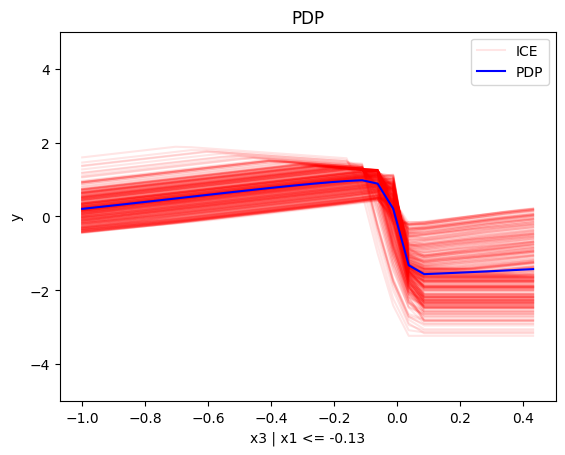

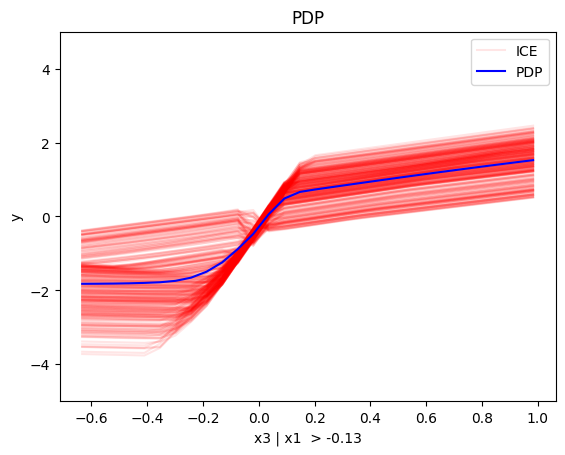

In [52]:
regional_pdp.plot(feature=2, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
regional_pdp.plot(feature=2, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

#### Conclusion

## (RH)ALE

In [53]:
def model_uncor_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model_uncor(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

def model_cor_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model_cor(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

### Uncorrelated setting

#### Global RHALE

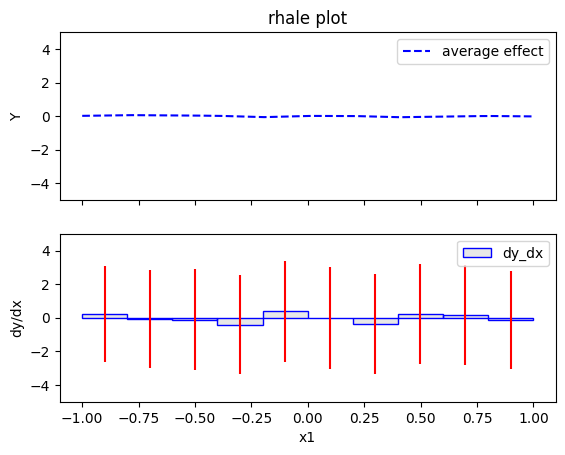

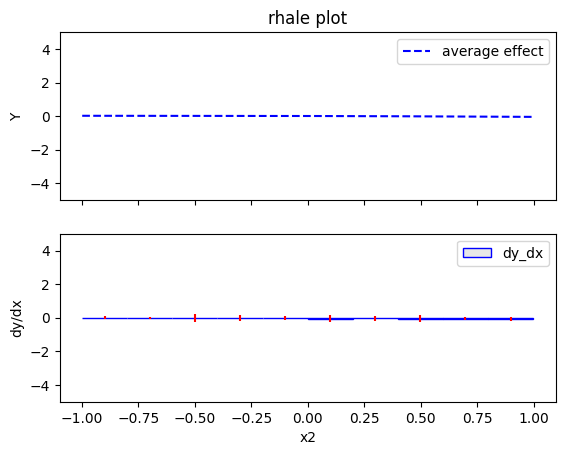

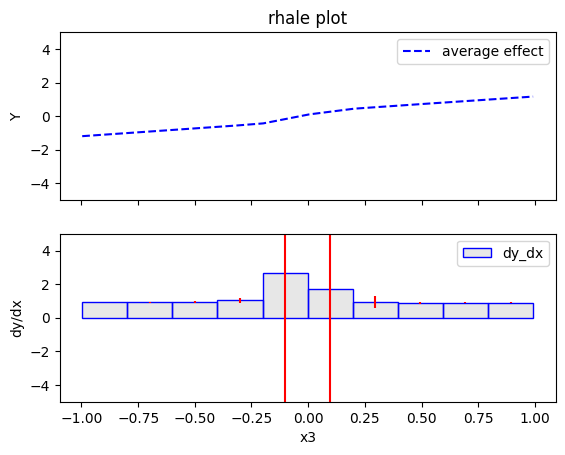

In [54]:
rhale = effector.RHALE(data=X_uncor_train, model=model_uncor, model_jac=model_uncor_jac, feature_names=['x1','x2','x3'], target_name="Y")

binning_method = effector.binning_methods.Fixed(10, min_points_per_bin=0)
rhale.fit(features="all", binning_method=binning_method, centering=True)

rhale.plot(feature=0, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=1, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=2, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])

#### Regional RHALE


In [55]:
regional_rhale = effector.RegionalRHALE(
    data=X_uncor_train, 
    model=model_uncor, 
    model_jac= model_uncor_jac, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

binning_method = effector.binning_methods.Fixed(11, min_points_per_bin=0)
regional_rhale.fit(
    features="all",
    heter_pcg_drop_thres=0.6,
    binning_method=binning_method,
    nof_candidate_splits_for_numerical=11
)


100%|██████████| 3/3 [00:00<00:00,  9.01it/s]


In [56]:
regional_rhale.show_partitioning(features=0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 5.92 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x1 | x3 <= -0.0, heter: 0.56 || nof_instances:   498 || weight: 0.50
        Node id: 2, name: x1 | x3  > -0.0, heter: 0.67 || nof_instances:   502 || weight: 0.50
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 5.92
        Level 1, heter: 0.62 || heter drop: 5.30 (89.61%)


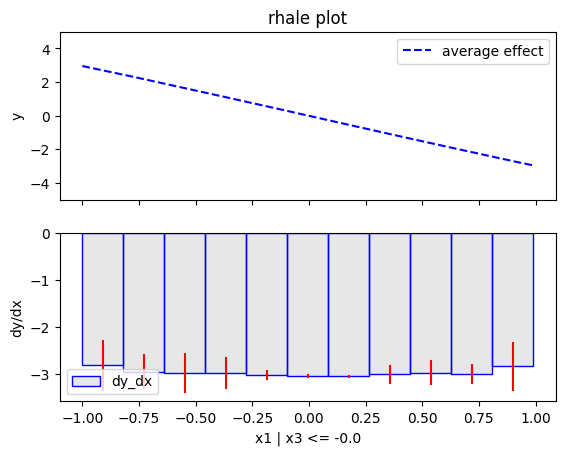

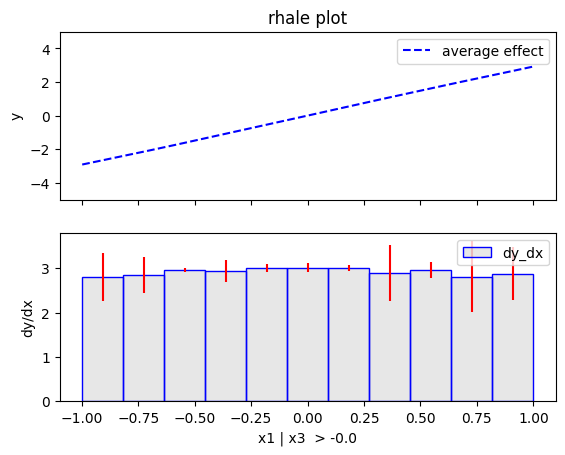

In [57]:
regional_rhale.plot(feature=0, node_idx=1, heterogeneity="std", centering=True, y_limits=[-5, 5])
regional_rhale.plot(feature=0, node_idx=2, heterogeneity="std", centering=True, y_limits=[-5, 5])

In [58]:
regional_rhale.show_partitioning(features=1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.29 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.29


In [59]:
regional_rhale.show_partitioning(features=2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 6.48 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 6.48


#### Conclusion

### Correlated setting

#### Global RHALE

In [60]:
rhale = effector.RHALE(data=X_cor_train, model=model_cor, model_jac=model_cor_jac, feature_names=['x1','x2','x3'], target_name="Y")

binning_method = effector.binning_methods.Fixed(10, min_points_per_bin=0)
rhale.fit(features="all", binning_method=binning_method, centering=True)

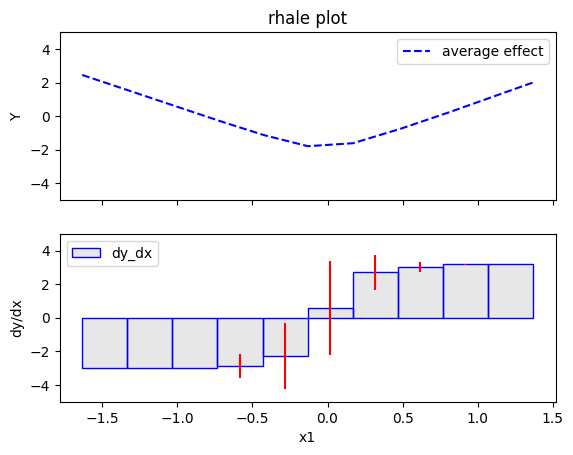

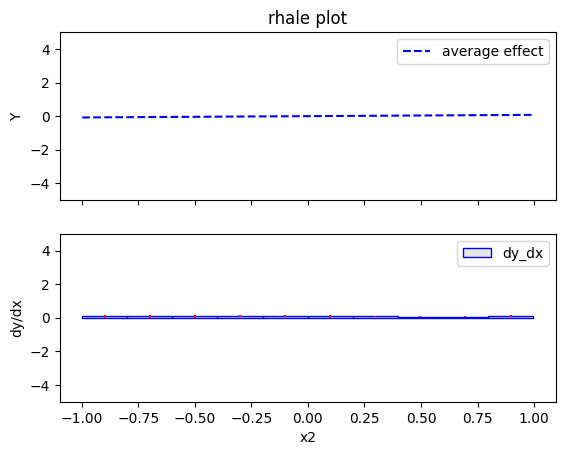

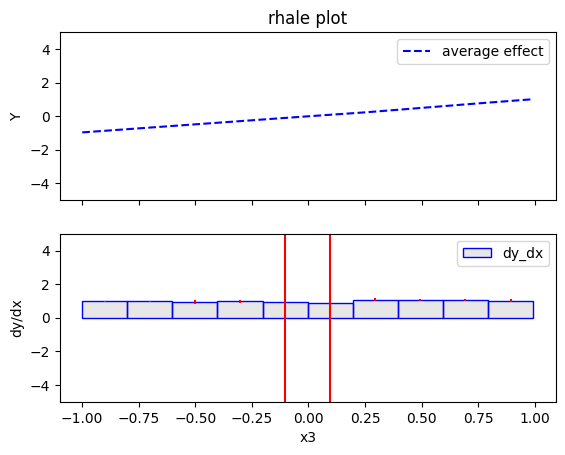

In [61]:
rhale.plot(feature=0, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=1, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=2, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])

#### Regional RHALE

In [62]:
regional_rhale = effector.RegionalRHALE(
    data=X_cor_train, 
    model=model_cor, 
    model_jac= model_cor_jac, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

binning_method = effector.binning_methods.Fixed(11, min_points_per_bin=0)
regional_rhale.fit(
    features="all",
    heter_pcg_drop_thres=0.6,
    binning_method=binning_method,
    nof_candidate_splits_for_numerical=11
)

100%|██████████| 3/3 [00:00<00:00,  6.31it/s]


In [63]:
regional_rhale.show_partitioning(features=0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 1.91 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 1.91


In [64]:
regional_rhale.show_partitioning(features=1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.13 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.13


In [65]:
regional_rhale.show_partitioning(features=2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 2.23 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 2.23


#### Conclusion

## SHAP DP
### Uncorrelated setting
#### Global SHAP DP


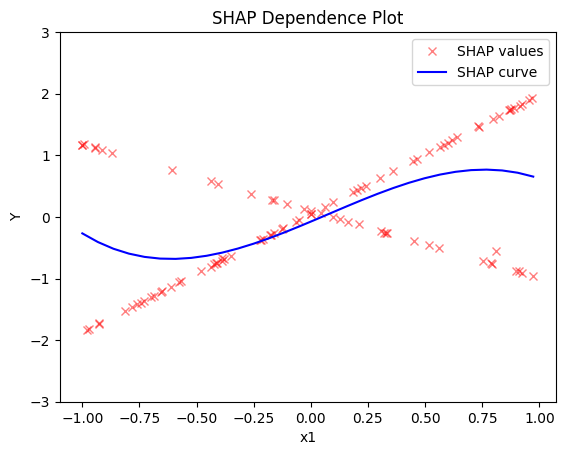

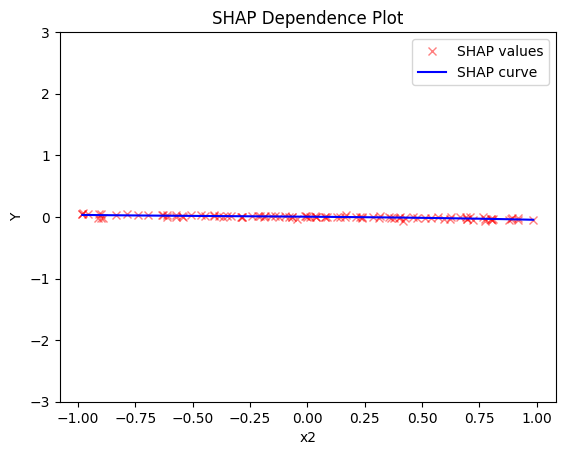

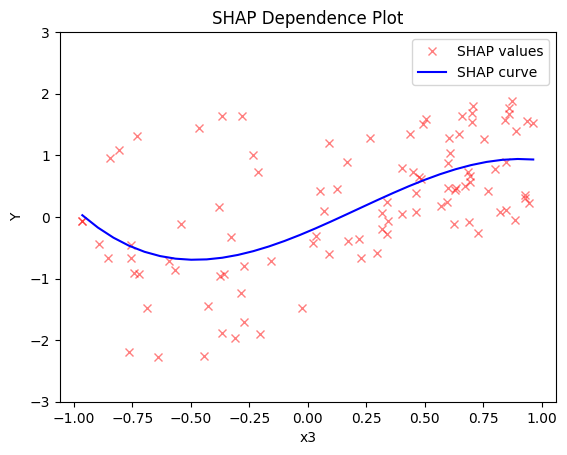

In [66]:
shap = effector.ShapDP(data=X_uncor_train, model=model_uncor, feature_names=['x1', 'x2', 'x3'], target_name="Y")

shap.plot(feature=0, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=1, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=2, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])


#### Regional SHAP-DP

In [67]:
regional_shap = effector.RegionalShapDP(
    data=X_uncor_train,
    model=model_uncor,
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T)

regional_shap.fit(
    features="all",
    heter_pcg_drop_thres=0.6,
    nof_candidate_splits_for_numerical=11
)


100%|██████████| 3/3 [00:27<00:00,  9.30s/it]


In [68]:
regional_shap.show_partitioning(0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 0.82 || nof_instances:   100 || weight: 1.00
        Node id: 1, name: x1 | x3 <= -0.0, heter: 0.02 || nof_instances:    51 || weight: 0.51
        Node id: 2, name: x1 | x3  > -0.0, heter: 0.01 || nof_instances:    49 || weight: 0.49
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 0.82
        Level 1, heter: 0.02 || heter drop: 0.80 (98.14%)


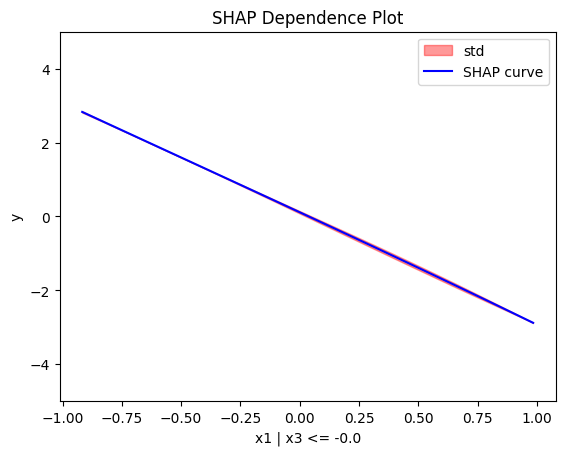

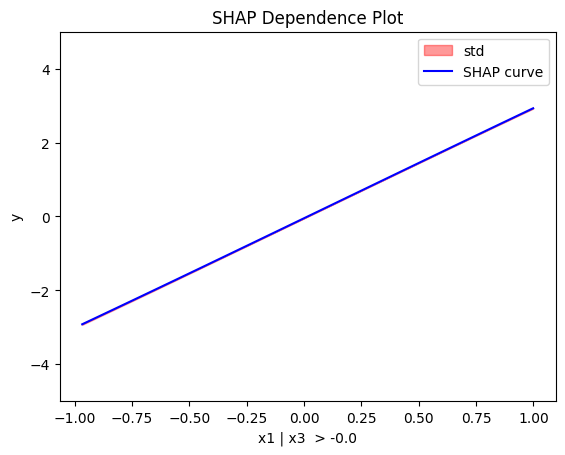

In [69]:
regional_shap.plot(feature=0, node_idx=1, heterogeneity="std", centering=True, y_limits=[-5, 5])
regional_shap.plot(feature=0, node_idx=2, heterogeneity="std", centering=True, y_limits=[-5, 5])

In [70]:
regional_shap.show_partitioning(features=1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.01 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.01


In [71]:
regional_shap.show_partitioning(features=2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 0.73 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 0.73


#### Conclusion

### Correlated setting

#### Global SHAP-DP


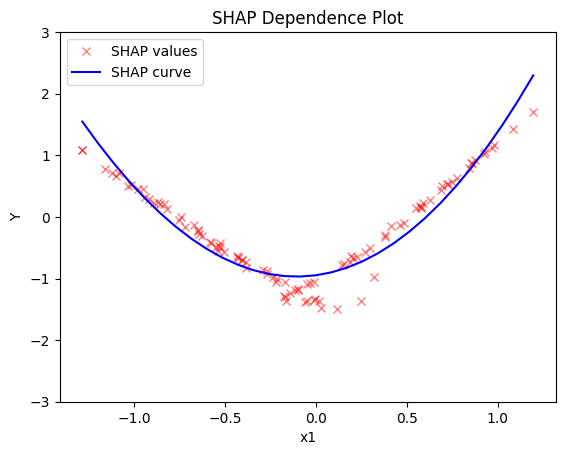

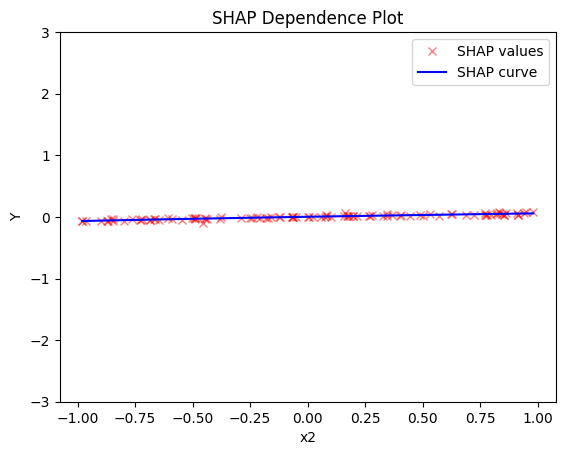

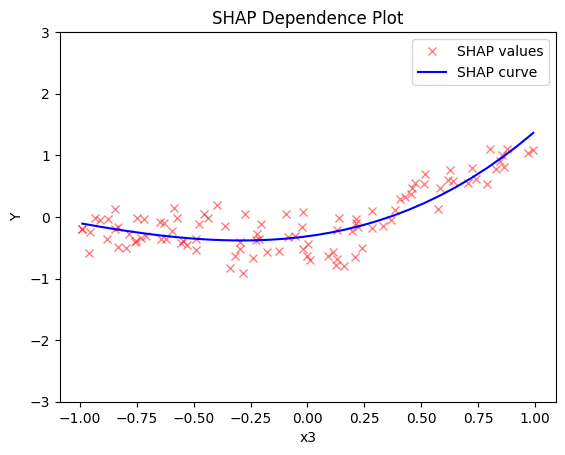

In [72]:

shap = effector.ShapDP(data=X_cor_train, model=model_cor, feature_names=['x1', 'x2', 'x3'], target_name="Y")

shap.plot(feature=0, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=1, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=2, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])


#### Regional SHAP

In [73]:
regional_shap = effector.RegionalShapDP(
    data=X_cor_train,
    model=model_cor,
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T)

regional_shap.fit(
    features="all",
    heter_pcg_drop_thres=0.6,
    nof_candidate_splits_for_numerical=11
)

100%|██████████| 3/3 [00:26<00:00,  8.68s/it]


In [74]:
regional_shap.show_partitioning(0)
regional_shap.show_partitioning(1)
regional_shap.show_partitioning(2)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 0.17 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 0.17
Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.01 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.01
Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 0.22 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 0.22


#### Conclusion

